In [8]:
import os
import numpy as np
import scanpy as sc
import pandas as pd
import glob

path = "/home/olle/PycharmProjects/LODE/workspace/feature_statistics/cell_data"

cell_pd = pd.read_csv(os.path.join(path, "feature_statistics.csv"))

cell_pd = cell_pd.drop(columns=["0", "11", "12", "14", "15"])
cell_pd.rename(columns={"13":"11"}, inplace=True)

In [9]:
# create adata object
var_names = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11"]

X = np.array(cell_pd[var_names])

obs_id = cell_pd.id
obs_cls = cell_pd.id.str.split("-", expand=True)[0]


adata = sc.AnnData(X=X)
adata.obs["obs_id"] = obs_id.values.tolist()
adata.obs["obs_cls"] = obs_cls.values.tolist()
adata.var["var_name"] = var_names

naming_map = {"1":"epiretinal membrane", "2":"neurosensory retina", "3":"intraretinal fluid",
              "4":"subretinal fluid", "5":"subretinal hyp. reflect. mat.", "6":"retinal pigment epithelium", 
              "7":"fibrovascular PED", "8":"drusenoid PED", "9":"posterior hyaloid membrane",
              "10":"choroid","11":"fibrosis"}

adata.var.var_name = adata.var.var_name.map(naming_map)

#### format index

In [10]:
adata.var.index = adata.var.index.astype(int) + 1
adata.var.index = adata.var.index.astype(str)

In [11]:
#### Add train test split to obs

In [12]:
test_image_path = "/home/olle/PycharmProjects/LODE/workspace/feature_statistics/cell_data/OCT2017/test"

test_ids_list = [i.split("/")[-1] for i in glob.glob(test_image_path + "/*/*")]

all_ids = pd.DataFrame(adata.obs["obs_id"])
test_ids = pd.DataFrame(test_ids_list)
test_paths = pd.DataFrame([test_ids_list, glob.glob(test_image_path + "/*/*")]).T

data_split_pd = pd.merge(all_ids, test_ids, left_on="obs_id", right_on=0, how="left")

data_split_pd["split"] = "train"
data_split_pd["split"][~data_split_pd[0].isna()] = "test"

adata.obs["split"] = data_split_pd.split.values.tolist()

#### add image path to adata object

In [13]:
# adata_test.obs["img_path"] = test_image_path + "/" + adata_test.obs.obs_cls + "/" + adata_test.obs.obs_id

### Preprocessing

In [14]:
# Log and norm data

In [15]:
sc.pp.log1p(adata)

In [16]:
# create adata test object
adata_test = adata[adata.obs.split == "test"]

In [17]:
### PCA analysis

In [18]:
sc.tl.pca(adata_test,n_comps=10, svd_solver='arpack')


... storing 'obs_id' as categorical
... storing 'obs_cls' as categorical
... storing 'split' as categorical


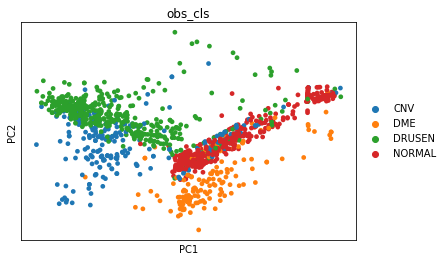

In [19]:
sc.pl.pca(adata_test, color='obs_cls')


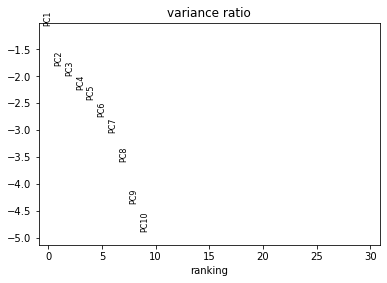

In [20]:
sc.pl.pca_variance_ratio(adata_test, log=True)


In [21]:
##### compte neighbour hood graph

In [92]:
sc.pp.neighbors(adata_test)
sc.tl.umap(adata_test)

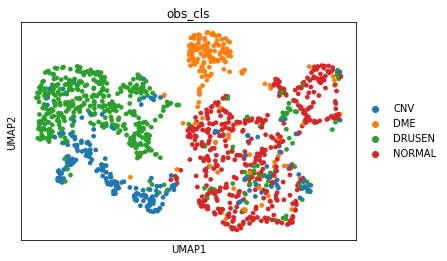

In [93]:
sc.pl.umap(adata_test, color=['obs_cls'])

<Figure size 1440x720 with 0 Axes>

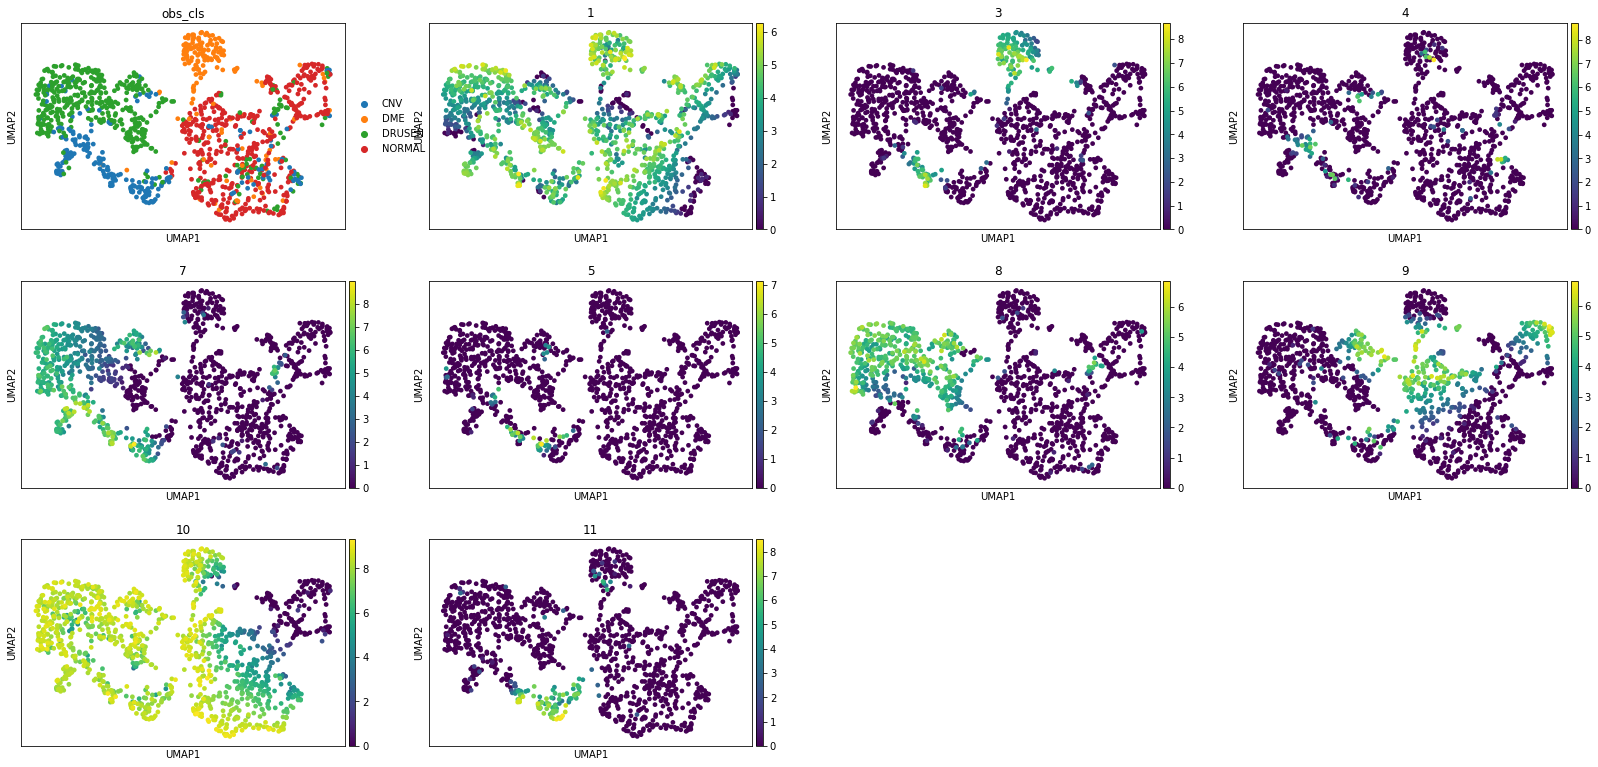

In [94]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
sc.pl.umap(adata_test, color=['obs_cls', "1", "3", "4", "7", "5", "8", "9", "10", "11"])

#### Clustering

In [25]:
sc.tl.leiden(adata_test)
sc.tl.louvain(adata_test)
sc.tl.paga(adata_test)

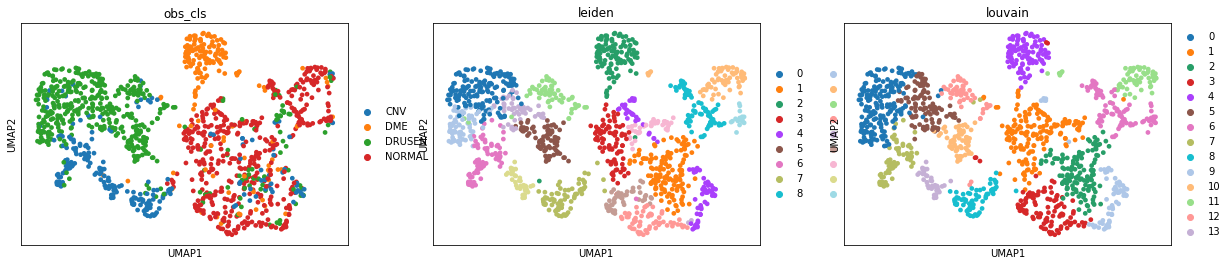

In [26]:
sc.pl.umap(adata_test, color=['obs_cls', "leiden", "louvain"])

In [27]:
#### Feature expression significance

In [28]:
print(__doc__)
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

print(__doc__)
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
from scipy.cluster import hierarchy

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

Automatically created module for IPython interactive environment
Automatically created module for IPython interactive environment


In [29]:
X_train = adata.X[adata.obs.split == "train"]
y_train = adata.obs.obs_cls[adata.obs.split == "train"]
X_test = adata.X[adata.obs.split == "test"]
y_test = adata.obs.obs_cls[adata.obs.split == "test"]

In [30]:
rf = Pipeline([
    ('classifier', RandomForestClassifier(n_estimators=50, random_state=42))
])

rf.fit(X_train, y_train)

Pipeline(steps=[('classifier',
                 RandomForestClassifier(n_estimators=50, random_state=42))])

In [31]:
print("RF train accuracy: %0.3f" % rf.score(X_train, y_train))
print("RF test accuracy: %0.3f" % rf.score(X_test, y_test))

RF train accuracy: 0.997
RF test accuracy: 0.873


RF train accuracy: 0.999
RF test accuracy: 0.944


(<sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x7fa5a06090d0>,
 <Figure size 432x288 with 1 Axes>)

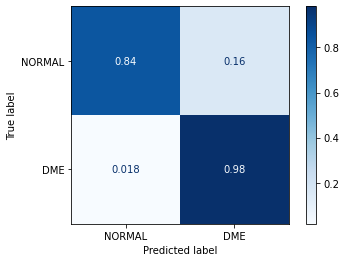

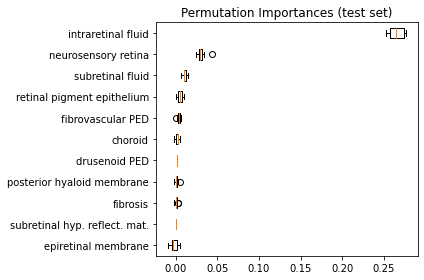

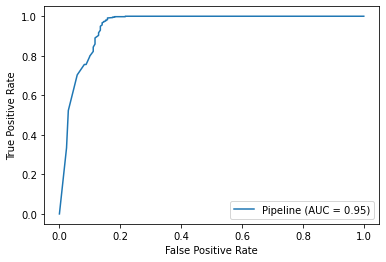

In [98]:
from copy import deepcopy
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn import linear_model
from sklearn.metrics import plot_roc_curve

def predict_binary_class(data_object, features):
    available_features = data_object.obs.obs_cls.unique()
    
    allowed_feature = [feature for feature in features if feature in available_features]
    for f in allowed_feature:
        assert f, f"invalid feature, feature must be in {available_features}"
    
    # make copy
    data_copy = deepcopy(data_object)
    
    # extract columns belong to feature
    feature_f = data_copy.obs.obs_cls.isin(features)
    
    # annotate all other to not feature class
    #data_copy.obs.obs_cls[~feature_f] = f"NOT_FEATURE"
    data_copy = data_copy[feature_f]
    
    X_train = data_copy.X[data_copy.obs.split == "train"]
    y_train = data_copy.obs.obs_cls[data_copy.obs.split == "train"]
    X_test = data_copy.X[data_copy.obs.split == "test"]
    y_test = data_copy.obs.obs_cls[data_copy.obs.split == "test"]
    
    rf = Pipeline([('classifier', RandomForestClassifier(n_estimators=50, random_state=42))])
    
    rf.fit(X_train, y_train)
    
    print("RF train accuracy: %0.3f" % rf.score(X_train, y_train))
    print("RF test accuracy: %0.3f" % rf.score(X_test, y_test))
    
    disp = plot_confusion_matrix(rf, X_test, y_test,
                                 display_labels=data_copy.obs.obs_cls.unique(),
                                 cmap=plt.cm.Blues,
                                 normalize="true")
    
    rfc_disp = plot_roc_curve(rf, X_test, y_test, ax=ax, alpha=0.8)
    
    
    # get feature importance
    result = permutation_importance(rf, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
    sorted_idx = result.importances_mean.argsort()

    perm_fig, perm_ax = plt.subplots()
    perm_ax.boxplot(result.importances[sorted_idx].T,
               vert=False, labels=adata.var.var_name[sorted_idx])
    perm_ax.set_title("Permutation Importances (test set)")
    perm_fig.tight_layout()
    
    return disp, rfc_disp, perm_fig
    
cm, roc, perm = predict_binary_class(adata, features=["DME", "NORMAL"]) # , "CNV", "NORMAL", "DME"
cm, roc.plot(), perm

## Permutation test for feature importance

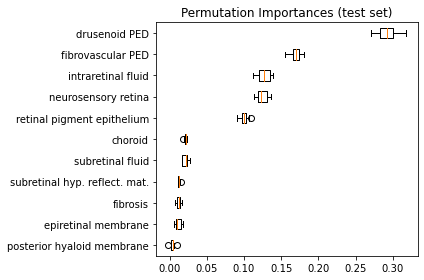

In [33]:
result = permutation_importance(rf, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=adata.var.var_name[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

## Controlling for Multicorrelation

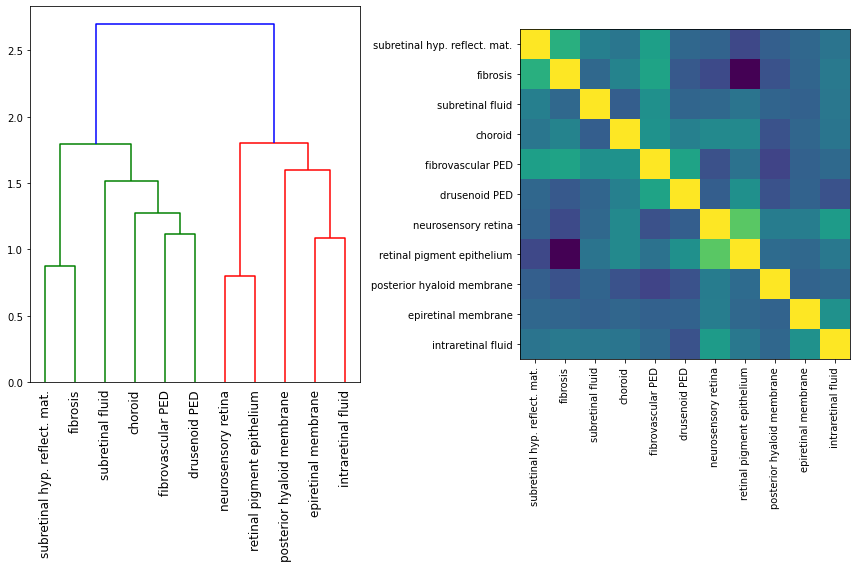

In [70]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(adata.X).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(
    corr_linkage, labels=adata.var.var_name.tolist(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
fig.tight_layout()
plt.show()

In [71]:
cluster_ids = hierarchy.fcluster(corr_linkage, 1, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
    
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

X_train_sel = X_train[:, selected_features]
X_test_sel = X_test[:, selected_features]

clf_sel = RandomForestClassifier(n_estimators=100, random_state=42)
clf_sel.fit(X_train_sel, y_train)

print("Accuracy on test data with features removed: {:.2f}".format(
      clf_sel.score(X_test_sel, y_test)))

Accuracy on test data with features removed: 0.88


In [85]:
cluster_ids
[v for v in cluster_id_to_feature_ids.values()]

[[0], [1, 5], [2], [3], [4, 10], [6], [7], [8], [9]]

In [87]:
sorted_idx

array([7, 4, 3, 0, 8, 1, 2, 5, 6])

In [86]:
adata.var.var_name

1               epiretinal membrane
2               neurosensory retina
3                intraretinal fluid
4                  subretinal fluid
5     subretinal hyp. reflect. mat.
6        retinal pigment epithelium
7                 fibrovascular PED
8                     drusenoid PED
9        posterior hyaloid membrane
10                          choroid
11                         fibrosis
Name: var_name, dtype: object

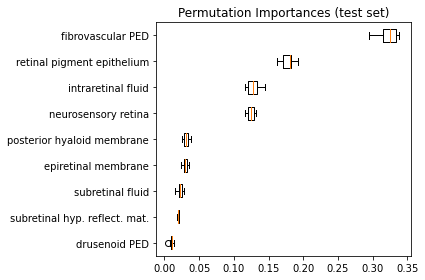

In [77]:
result = permutation_importance(clf_sel, X_test_sel, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=adata.var.var_name[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()